# Create transactions subgraph with 25% HI-Small data


## 📄 Notebook Summary

This notebook creates a smaller, focused version of a large transaction dataset to make it easier to use for graph machine learning. Training a Graph Neural Network (GNN) on the full dataset takes a long time — for example, training on the **HI-Small_Trans.csv** dataset from [IBM's AML dataset](https://www.kaggle.com/datasets/ealtman2019/ibm-transactions-for-anti-money-laundering-aml) reportedly took over 21 hours ([source](https://arxiv.org/abs/2306.16424)). To make experimentation faster and more efficient, we aim to create a representative **subset of about 25%** of the original data.

### Subsetting strategy:
- We want to avoid having **orphan transactions** (edges with no nearby structure), since GNNs learn best from connected neighborhoods.
- Following our instructor’s suggestion, we also include **all illicit transactions** in the subset. This ensures we preserve rare but important examples of money laundering, which would otherwise be heavily underrepresented or entirely missed.

### Here's what this notebook does:
- Builds a graph where each transaction is a directed edge between two accounts.
- Identifies all transactions labeled as **illicit** (i.e., money laundering cases).
- Gathers nearby transactions using a **k-hop neighborhood search** to capture context around illicit activity.
- Samples additional **licit transactions** (non-illicit) and collects some of their surrounding transactions as well.
- Merges these parts to form a **smaller, well-connected subset** — about 25% of the full dataset.
- Ensures everything stays properly aligned, even when there are **multiple transactions between the same accounts**.
- Prepares the final subset for saving and future use in GNN training.

This process gives us a smaller dataset that still contains meaningful structure and rare illicit behavior, making it ideal for building and testing a GNN baseline model.

### Output
Dataset `subset_transactions.csv`:
* 1250901 transactions (24.6% of HI-Small.csv)
* 0.414% of transactions are illicit (vs ~0.1% in HI-Small)

## Notebook configuration

In [3]:
import random
import networkx as nx
import pandas as pd
import numpy as np
import ipywidgets as widgets
import os
import sys
import matplotlib.pyplot as plt
import warnings
from tabulate import tabulate
from tqdm import trange
from IPython import get_ipython
from IPython.display import display
from time import monotonic
from pprint import pprint
from google.colab import drive

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
from torch.nn import BCEWithLogitsLoss, Sequential, Linear, ReLU
!pip install torch-geometric
from torch_geometric.nn import GCNConv, SAGEConv, GATConv, EdgeConv, GINEConv
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
!pip install torchmetrics
from torchmetrics.classification import Recall, Accuracy, AUROC, Precision
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')

content_base = "/content/drive"
drive.mount(content_base)

# Project data
data_dir = os.path.join(content_base, "My Drive/Capstone/data")
data_file = os.path.join(data_dir, "HI-Small_Trans.csv")

# # Project Source Code
# src_path = os.path.join(content_base, "My Drive/Capstone/src")
# sys.path.append(src_path)
# from helpers import add_cell_timer
# from pipeline import ModelPipeline

# add_cell_timer()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# Google Colaboratory executes in an environment with a file system
# that has a Linux topography, but where the user should work under
# the `/content` directory
COLAB_ROOT = "/content"

REPO_URL = "https://github.com/engie4800/dsi-capstone-spring-2025-TD-anti-money-laundering.git"
REPO_ROOT = os.path.join(COLAB_ROOT, REPO_URL.split("/")[-1].split(".")[0])
REPO_BRANCH = "sophie"

# Clones the repository at `/content/dsi-capstone-spring-2025-TD-anti-money-laundering`
if not os.path.exists(REPO_ROOT):
  os.chdir(COLAB_ROOT)
  !git clone {REPO_URL}

# Pulls the latest code from the provided branch and adds the
# analysis pipeline source code to the Python system path
os.chdir(REPO_ROOT)
!git pull
!git checkout {REPO_BRANCH}
sys.path.append(os.path.join(REPO_ROOT, "Code/src"))
os.chdir(COLAB_ROOT)

Already up to date.
Already on 'sophie'
Your branch is up to date with 'origin/sophie'.


In [5]:
from helpers import add_cell_timer
from pipeline import ModelPipeline
add_cell_timer()

## Initialize model pipeline

In [61]:
pl = ModelPipeline(data_file)
pl.rename_columns()
pl.drop_duplicates()
pl.create_unique_ids()

Creating unique ids...


⏱️ Execution time: 33.69s


## Peak at the data

In [62]:
pl.df.head()

,timestamp,from_bank,to_bank,received_amount,received_currency,sent_amount,sent_currency,payment_type,is_laundering,from_account_id,to_account_id,from_account_idx,to_account_idx
0,2022/09/01 00:20,10,10,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0,10_8000EBD30,10_8000EBD30,0,0
1,2022/09/01 00:20,3208,1,0.01,US Dollar,0.01,US Dollar,Cheque,0,3208_8000F4580,1_8000F5340,1,399662
2,2022/09/01 00:00,3209,3209,14675.57,US Dollar,14675.57,US Dollar,Reinvestment,0,3209_8000F4670,3209_8000F4670,2,2
3,2022/09/01 00:02,12,12,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0,12_8000F5030,12_8000F5030,3,3
4,2022/09/01 00:06,10,10,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0,10_8000F5200,10_8000F5200,4,4



⏱️ Execution time: 0.04s


In [63]:
reinv_mask = pl.df['payment_type'] == 'Reinvestment'
reinv_total = reinv_mask.sum()
total = len(pl.df)
reinv_illicit = ((reinv_mask) & (pl.df['is_laundering'] == 1)).sum()
print("Percent of transactions that are `Reinvestment`:", round(reinv_total / total * 100, 2), "%")
print("Percent of `Reinvestment` transactions that are illicit:", round(reinv_illicit / reinv_total * 100, 2), "%")

Percent of transactions that are `Reinvestment`: 9.47 %
Percent of `Reinvestment` transactions that are illicit: 0.0 %

⏱️ Execution time: 0.39s


**Comment**

About 9.5% of transactions are reinvestments. This means a self-loop, with `from_account_idx` == `to_account_idx`.
* May need to normalize this separately if transactions are different from other types
* Should look at EDA vs other transactions
* See if there is a correlation with illicit behavior
  * No reinvestment txns are labeled illicit
* For catboost, possibly encode:
  * `num_self_loops`
  * `total_self_volume`
  * `self_txn_ratio`
* Some people chose to collapse self-loops into node features, instead of keeping them as edges
* ❗revisit this

# Create subgraph containing all licit transactions

## Preliminary counts of nodes and edges at k-hop

In [64]:
from torch_geometric.utils import k_hop_subgraph

# Build edge index and get labels
edge_index = torch.tensor(pl.df[['from_account_idx', 'to_account_idx']].values.T, dtype=torch.long)
edge_label = torch.tensor(pl.df['is_laundering'].values, dtype=torch.long)

# Construct Data object
data = Data(edge_index=edge_index)
data.num_nodes = max(pl.df[['from_account_idx', 'to_account_idx']].values.flatten()) + 1

# Get edges with is_laundering==1 and nodes involved
illicit_edge_mask = edge_label == 1
illicit_edge_indices = illicit_edge_mask.nonzero(as_tuple=False).view(-1)
illicit_nodes = edge_index[:, illicit_edge_indices].flatten().unique()

# Print % illicit
print("Percent illicit in HI-Small: ", round(illicit_edge_mask.sum().item()/len(illicit_edge_mask)*100,3),"%") # 0.1% illicit in HI-Small

Percent illicit in HI-Small:  0.102 %

⏱️ Execution time: 0.91s


In [65]:
# Choose your seed nodes (e.g., illicit_nodes)
seed_nodes = illicit_nodes  # torch tensor of node indices

# Full edge_index
ei = edge_index

# Storage for node sets at each level
hop_0 = seed_nodes
hop_1, _, _, _ = k_hop_subgraph(seed_nodes, num_hops=1, edge_index=ei, relabel_nodes=False)
hop_2, _, _, _ = k_hop_subgraph(seed_nodes, num_hops=2, edge_index=ei, relabel_nodes=False)
hop_3, _, _, _ = k_hop_subgraph(seed_nodes, num_hops=3, edge_index=ei, relabel_nodes=False)
hop_4, _, _, _ = k_hop_subgraph(seed_nodes, num_hops=4, edge_index=ei, relabel_nodes=False)
hop_5, _, _, _ = k_hop_subgraph(seed_nodes, num_hops=5, edge_index=ei, relabel_nodes=False)

# Get only the new nodes at each hop level
hop_1_only = torch.tensor(list(set(hop_1.tolist()) - set(hop_0.tolist())))
hop_2_only = torch.tensor(list(set(hop_2.tolist()) - set(hop_1.tolist())))
hop_3_only = torch.tensor(list(set(hop_3.tolist()) - set(hop_2.tolist())))
hop_4_only = torch.tensor(list(set(hop_4.tolist()) - set(hop_3.tolist())))
hop_5_only = torch.tensor(list(set(hop_5.tolist()) - set(hop_4.tolist())))

# Print sizes
print("Num 0-hop nodes (seeds):", len(hop_0))
print("Num 1-hop-only nodes:", len(hop_1_only))
print("Num 2-hop-only nodes:", len(hop_2_only))
print("Num 3-hop-only nodes:", len(hop_3_only))
print("Num 4-hop-only nodes:", len(hop_4_only))
print("Num 5-hop-only nodes:", len(hop_5_only))

# Optional: total reach within k hops
print("Total 1-hop neighborhood:", len(hop_1))
print("Total 2-hop neighborhood:", len(hop_2))
print("Total 3-hop neighborhood:", len(hop_3))
print("Total 4-hop neighborhood:", len(hop_4))
print("Total 5-hop neighborhood:", len(hop_5))

Num 0-hop nodes (seeds): 6357
Num 1-hop-only nodes: 14932
Num 2-hop-only nodes: 11268
Num 3-hop-only nodes: 10388
Num 4-hop-only nodes: 9532
Num 5-hop-only nodes: 7524
Total 1-hop neighborhood: 21289
Total 2-hop neighborhood: 32557
Total 3-hop neighborhood: 42945
Total 4-hop neighborhood: 52477
Total 5-hop neighborhood: 60001

⏱️ Execution time: 0.54s


In [66]:
def count_edges_at_k_hop(seed_nodes, k, edge_index):
    sub_nodes, sub_edge_index, edge_mask, _ = k_hop_subgraph(
        node_idx=seed_nodes,
        num_hops=k,
        edge_index=edge_index,
        relabel_nodes=False,
        flow="source_to_target"
    )
    return edge_mask.sum().item(), sub_nodes.numel()

for k in range(1, 6):
    n_edges, n_nodes = count_edges_at_k_hop(illicit_nodes, k, edge_index)
    print(f"{k}-hop: {n_nodes} nodes | {n_edges} edges")


1-hop: 21289 nodes | 64811780 edges
2-hop: 32557 nodes | 102240242 edges
3-hop: 42945 nodes | 138910862 edges
4-hop: 52477 nodes | 170853817 edges
5-hop: 60001 nodes | 194828145 edges

⏱️ Execution time: 0.5s


### Number of edges per node

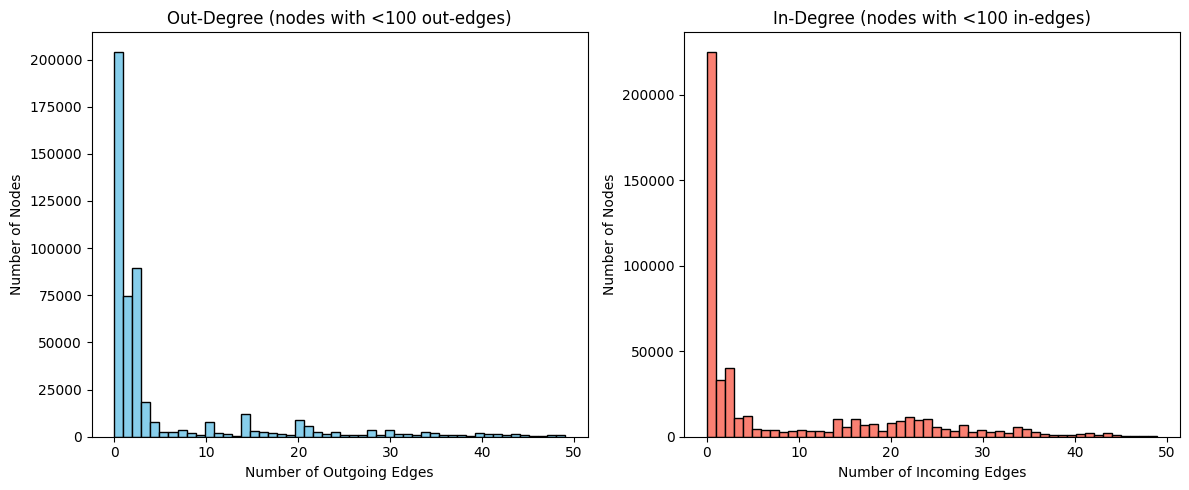


⏱️ Execution time: 2.66s


In [67]:
import matplotlib.pyplot as plt

out_degree_filtered = out_degree[out_degree < 50]
in_degree_filtered = in_degree[in_degree < 50]

# Plot histograms
plt.figure(figsize=(12, 5))

# Out-degree
plt.subplot(1, 2, 1)
plt.hist(out_degree_filtered.tolist(), bins=50, color='skyblue', edgecolor='black')
plt.title("Out-Degree (nodes with <100 out-edges)")
plt.xlabel("Number of Outgoing Edges")
plt.ylabel("Number of Nodes")

# In-degree
plt.subplot(1, 2, 2)
plt.hist(in_degree_filtered.tolist(), bins=50, color='salmon', edgecolor='black')
plt.title("In-Degree (nodes with <100 in-edges)")
plt.xlabel("Number of Incoming Edges")
plt.ylabel("Number of Nodes")

plt.tight_layout()
plt.show()

In [68]:
# edge_index shape: [2, num_edges]
src_nodes = edge_index[0]
dst_nodes = edge_index[1]

# Count out-edges (edges from each node)
out_degree = torch.bincount(src_nodes, minlength=data.num_nodes)

# Count in-edges (edges to each node)
in_degree = torch.bincount(dst_nodes, minlength=data.num_nodes)

print("number of nodes with 1 out:", (out_degree == 1).sum().item())
print("number of nodes with 1 in:", (in_degree == 1).sum().item())
print("number of nodes with 1 out and 0 in:", ((out_degree == 1) | (in_degree == 1)).sum().item())

number of nodes with 1 out: 152754
number of nodes with 1 in: 113645
number of nodes with 1 out and 0 in: 192404

⏱️ Execution time: 0.04s


## Build subset df from illicit transactions + neighbors

STEP 1: Build edge_index and label tensors

In [69]:
from torch_geometric.utils import k_hop_subgraph
edge_index = torch.tensor(pl.df[['from_account_idx', 'to_account_idx']].values.T, dtype=torch.long)
edge_label = torch.tensor(pl.df['is_laundering'].values, dtype=torch.long)
edge_to_row = torch.arange(len(pl.df))  # maps edge_index column to DataFrame row


⏱️ Execution time: 0.09s


STEP 2: Identify illicit edges and their nodes

In [70]:
illicit_edge_mask = edge_label == 1
illicit_edge_indices = illicit_edge_mask.nonzero(as_tuple=False).view(-1)
illicit_nodes = edge_index[:, illicit_edge_indices].flatten().unique()

print("Percent illicit in HI-Small:", round(illicit_edge_mask.sum().item() / len(pl.df) * 100, 3), "%")

Percent illicit in HI-Small: 0.102 %

⏱️ Execution time: 0.02s


STEP 3: Extract k-hop neighborhood around illicit nodes

In [71]:
subset_nodes, _, _, edge_mask = k_hop_subgraph(
    node_idx=illicit_nodes,
    num_hops=10,
    edge_index=edge_index,
    relabel_nodes=False
)

illicit_neighbor_edge_indices = edge_mask.nonzero(as_tuple=False).view(-1)
illicit_df_indices = edge_to_row[illicit_neighbor_edge_indices]
illicit_subgraph_df = pl.df.iloc[illicit_df_indices.tolist()].copy()

print("Illicit subgraph size:", len(illicit_subgraph_df))
print("Percent of HI-Small:", round(len(illicit_subgraph_df) / len(pl.df) * 100, 3), "%")

Illicit subgraph size: 785334
Percent of HI-Small: 15.464 %

⏱️ Execution time: 0.75s


## Add licit edges to reach ~25% of df

STEP 4: Sample additional licit edges to reach 25%

In [72]:
target_total = int(0.25 * len(pl.df))
needed = max(0, target_total - len(illicit_subgraph_df))

# Exclude already-included edges
licit_df = pl.df[(pl.df['is_laundering'] == 0) & (~pl.df.index.isin(illicit_df_indices.tolist()))].copy()

print("Total available licit edges:", len(licit_df))

# Sample a portion of needed licit edges (oversample a bit for neighborhood coverage)
sample_size = min(int(needed / 60), len(licit_df))  # adjustable oversampling factor
sampled_licit_df = licit_df.sample(n=sample_size, random_state=42)
sampled_licit_indices = sampled_licit_df.index.tolist()
sampled_licit_edge_indices = torch.tensor(sampled_licit_indices, dtype=torch.long)

# Get all involved nodes for the sampled licit edges
sampled_node_ids = np.unique(np.concatenate([
    sampled_licit_df['from_account_idx'].values,
    sampled_licit_df['to_account_idx'].values
]))
sampled_node_tensor = torch.tensor(sampled_node_ids, dtype=torch.long)

print(f"Sampled licit edges: {len(sampled_licit_indices)} | Nodes involved: {len(sampled_node_ids)}")

Total available licit edges: 4293002
Sampled licit edges: 8070 | Nodes involved: 13983

⏱️ Execution time: 1.73s


STEP 5: Extract k-hop neighborhood around sampled licit nodes

In [73]:
sampled_sub_nodes, _, _, sampled_edge_mask = k_hop_subgraph(
    node_idx=sampled_node_tensor,
    num_hops=2,
    edge_index=edge_index,
    relabel_nodes=False
)

sampled_neighbor_edge_indices = sampled_edge_mask.nonzero(as_tuple=False).view(-1)

# Combine with sampled licit edges explicitly (in case any are dropped in k-hop)
sampled_combined_edge_indices = torch.unique(torch.cat([
    sampled_neighbor_edge_indices,
    sampled_licit_edge_indices
]))


⏱️ Execution time: 0.11s


STEP 6: Combine illicit subgraph with sampled licit subgraph

In [74]:
final_df_row_indices = torch.unique(torch.cat([
    illicit_df_indices,
    sampled_combined_edge_indices
]))

final_subset_df = pl.df.iloc[final_df_row_indices.tolist()].copy()

print("Final subset size:", len(final_subset_df))
print("Percent of HI-Small:", round(len(final_subset_df) / len(pl.df) * 100, 3), "%")

Final subset size: 1250901
Percent of HI-Small: 24.632 %

⏱️ Execution time: 0.47s


Take a look at the data before saving:

In [77]:
final_subset_df.reset_index(drop=True, inplace=True)
final_subset_df.head()

,timestamp,from_bank,to_bank,received_amount,received_currency,sent_amount,sent_currency,payment_type,is_laundering,from_account_id,to_account_id,from_account_idx,to_account_idx
0,2022/09/01 00:20,10,10,3697.34,US Dollar,3697.34,US Dollar,Reinvestment,0,10_8000EBD30,10_8000EBD30,0,0
1,2022/09/01 00:20,3208,1,0.01,US Dollar,0.01,US Dollar,Cheque,0,3208_8000F4580,1_8000F5340,1,399662
2,2022/09/01 00:02,12,12,2806.97,US Dollar,2806.97,US Dollar,Reinvestment,0,12_8000F5030,12_8000F5030,3,3
3,2022/09/01 00:06,10,10,36682.97,US Dollar,36682.97,US Dollar,Reinvestment,0,10_8000F5200,10_8000F5200,4,4
4,2022/09/01 00:03,1,1,6162.44,US Dollar,6162.44,US Dollar,Reinvestment,0,1_8000F5AD0,1_8000F5AD0,5,5



⏱️ Execution time: 0.01s


In [80]:
print("Total transactions: ", len(final_subset_df))
print("Percent of illicit transactions:", round(len(final_subset_df[final_subset_df['is_laundering'] == 1]) / len(final_subset_df) * 100, 3), "%")

Total transactions:  1250901
Percent of illicit transactions: 0.414 %

⏱️ Execution time: 0.01s


## Save to CSV

Initial save:

In [ ]:
# final_subset_df.to_csv((os.path.join(data_dir, "subset_transactions.csv")), index=False)
# print("Saved to subset_transactions.csv")

Before saving, we need to return format to IBM original format:

In [ ]:
mymap = {
            "Timestamp": "timestamp",
            "From Bank": "from_bank",
            "Account": "from_account",
            "To Bank": "to_bank",
            "Account.1": "to_account",
            "Amount Received": "received_amount",
            "Receiving Currency": "received_currency",
            "Amount Paid": "sent_amount",
            "Payment Currency": "sent_currency",
            "Payment Format": "payment_type",
            "Is Laundering": "is_laundering",
        }
inv_map = {v: k for k, v in mymap.items()}
final_subset_df.rename(columns=inv_map, inplace=True)

In [ ]:
final_subset_df['Account'] = final_subset_df['from_account_id'].str.split("_").str[1]
final_subset_df['Account.1'] = final_subset_df['to_account_id'].str.split("_").str[1]
final_subset_df.drop(columns=['from_account_id', 'to_account_id','from_account_idx','to_account_idx'], inplace=True)
final_subset_df.head()

In [ ]:
new_order=['Timestamp','From Bank','Account','To Bank','Account.1','Amount Received','Receiving Currency','Amount Paid','Payment Currency','Payment Format','Is Laundering']
final_subset_df = final_subset_df[new_order]
final_subset_df.to_csv((os.path.join(data_dir, "subset_transactions2.csv")), index=False)